# Momentum vs. share gain

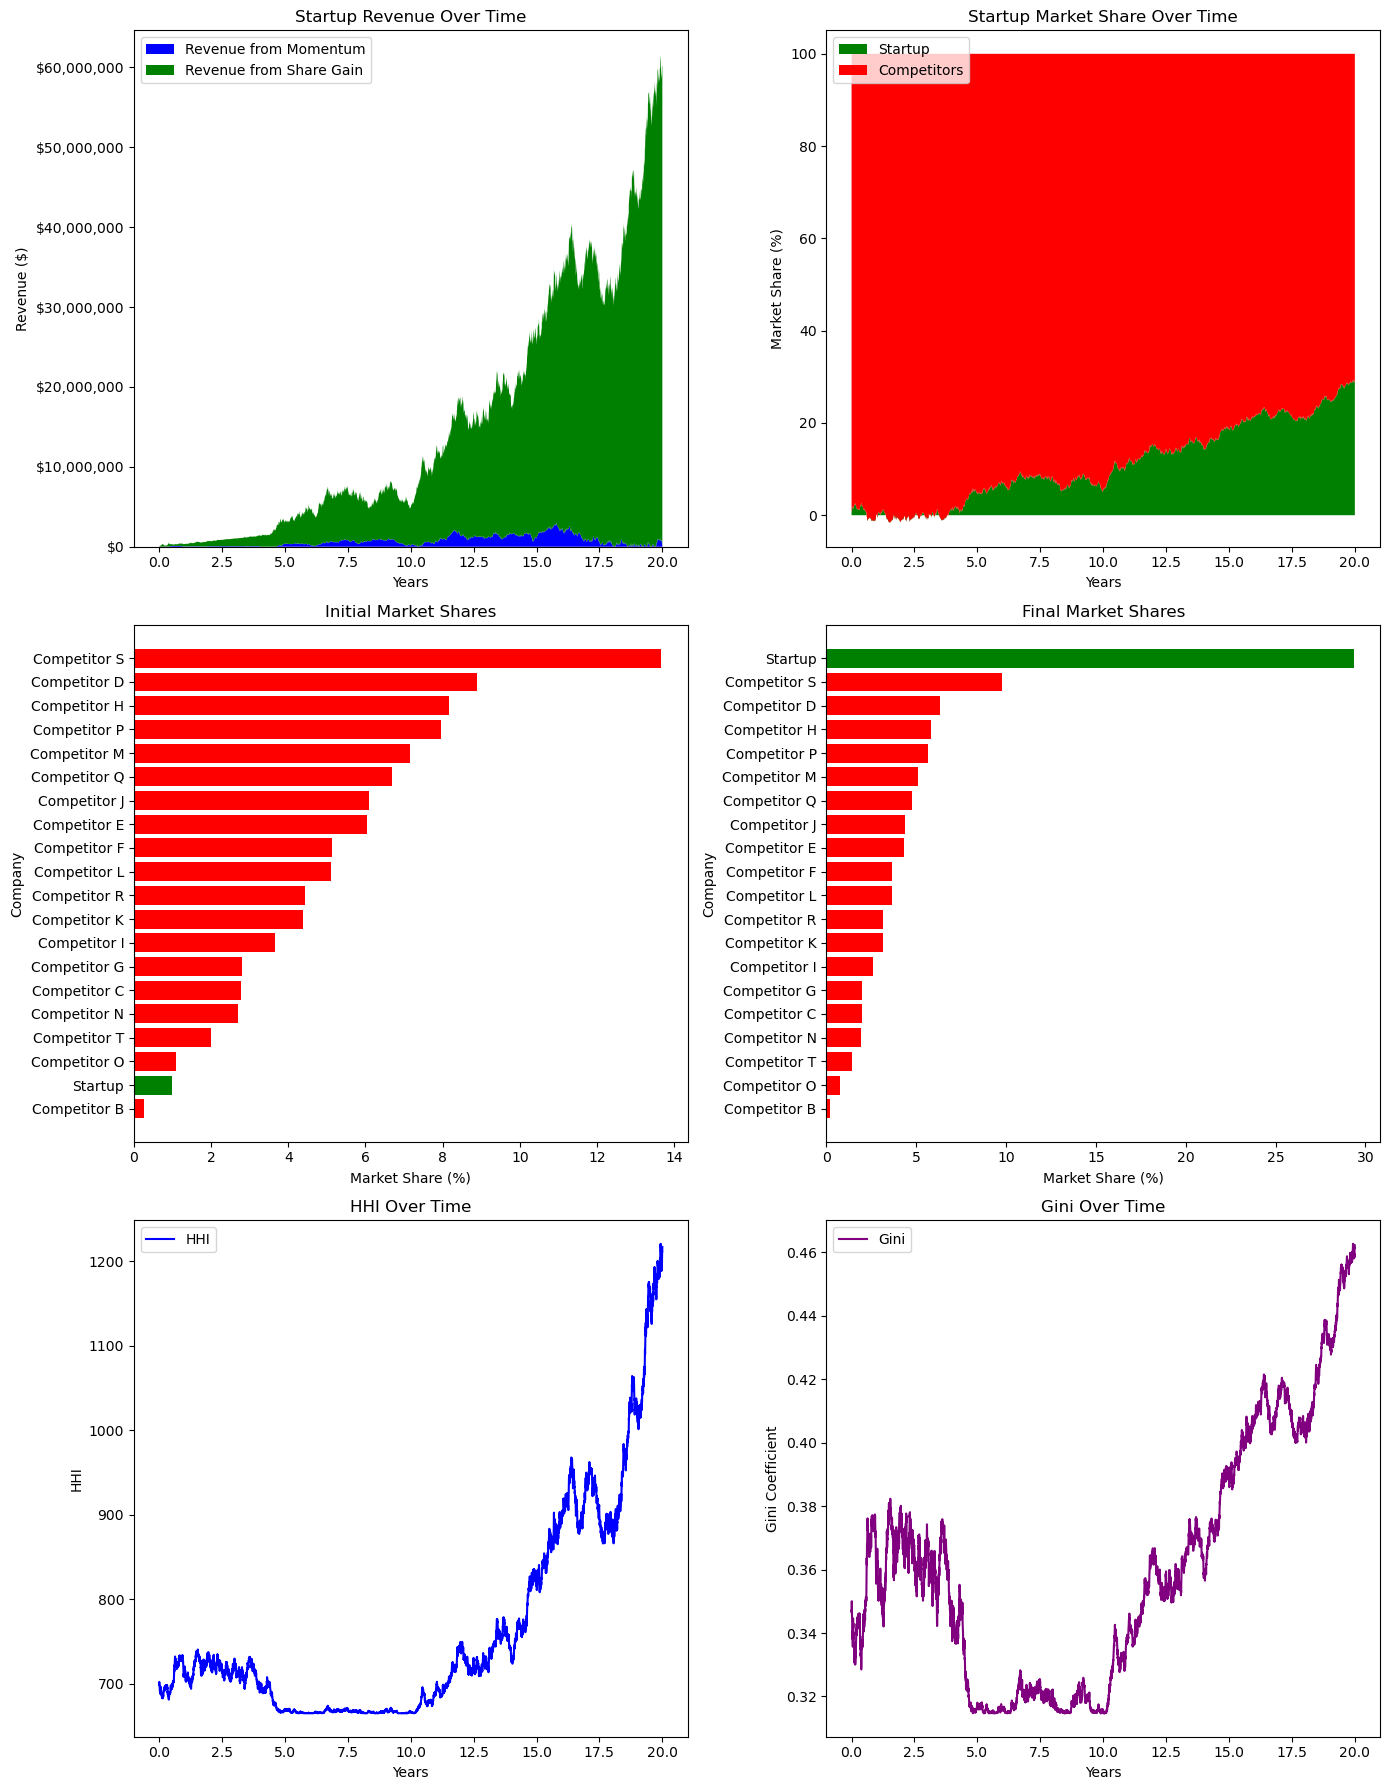

(array([0.29349245, 0.00194645, 0.0198934 , 0.06339336, 0.04313805,
        0.03668312, 0.01990381, 0.05831156, 0.02603876, 0.04352552,
        0.03132157, 0.03650169, 0.0509772 , 0.01924479, 0.00776844,
        0.05678585, 0.04769782, 0.03168855, 0.09749579, 0.01419182]),
 [698.9787066155166,
  698.2899646227108,
  699.9627369694838,
  701.9223099411612,
  700.5303930582329,
  700.8575629725915,
  699.6021498185827,
  697.7860167035786,
  696.1444452250266,
  693.8383322756829,
  692.1802592571728,
  690.6422755294642,
  690.7342915327287,
  689.92852724948,
  692.3663428490366,
  690.3896129271355,
  690.0567924929745,
  688.060685613243,
  687.6355331097501,
  689.6012323286338,
  693.0297314046475,
  693.8844080882255,
  696.3559317409025,
  693.242076177273,
  694.2631585954913,
  694.8443324748224,
  692.4022731928516,
  691.5046854822313,
  690.1046580416365,
  691.8956274900254,
  691.6201925203055,
  689.6405001839655,
  689.2589093838177,
  688.7031122517625,
  688.0438831990

In [99]:
import numpy as np
import matplotlib.pyplot as plt

def logistic_growth(market_size, growth_rate, market_saturation_size):
    return market_size * growth_rate * (1 - market_size / market_saturation_size)

def simulate_market(initial_shares, growth_rate, growth_volatility, steal_rate, steal_volatility, time_periods, initial_market_size, market_saturation_size, momentum=True, share_gain=False, saturation=False, noise=False):
    num_companies = len(initial_shares)
    shares = np.array(initial_shares)
    market_size = initial_market_size
    history = [shares.copy()]
    market_sizes = [market_size]
    hhi_history = [calculate_hhi(shares)]
    gini_history = [calculate_gini(shares)]
    
    daily_growth_rate = growth_rate / 365
    daily_growth_volatility = growth_volatility / 365
    daily_steal_rate = steal_rate / 365
    daily_steal_volatility = steal_volatility / 365
    daily_time_periods = time_periods * 365

    # Track the revenue from momentum and share gain separately
    revenue_from_momentum = np.zeros(daily_time_periods + 1)
    revenue_from_share_gain = np.zeros(daily_time_periods + 1)
    
    for t in range(daily_time_periods):
        if noise:
            growth_rate_noise = np.random.normal(daily_growth_rate, daily_growth_volatility)
            steal_rate_noise = np.random.normal(daily_steal_rate, daily_steal_volatility)
        else:
            growth_rate_noise = daily_growth_rate
            steal_rate_noise = daily_steal_rate
        
        if momentum:
            if saturation:
                growth_increment = logistic_growth(market_size, growth_rate_noise, market_saturation_size)
                market_size += growth_increment
            else:
                market_size *= (1 + growth_rate_noise)
            
            shares = shares * (1 + growth_rate_noise)
            shares /= shares.sum()  # Normalize to maintain shares summing to 1

            # Add revenue from momentum to the startup
            revenue_from_momentum[t + 1] = max(0, revenue_from_momentum[t] + shares[0] * market_size * growth_rate_noise)

        if share_gain:
            steal_amount = market_size * steal_rate_noise
            for i in range(num_companies):
                if i != 0:
                    shares[i] -= shares[i] * steal_rate_noise
                    shares[0] += shares[i] * steal_rate_noise
            shares /= shares.sum()  # Normalize to maintain shares summing to 1

            # Add revenue from share gain to the startup
            revenue_from_share_gain[t + 1] = max(0, revenue_from_share_gain[t] + shares[0] * steal_amount)

        history.append(shares.copy())
        market_sizes.append(market_size)
        hhi_history.append(calculate_hhi(shares))
        gini_history.append(calculate_gini(shares))
    
    return np.array(history), market_sizes, hhi_history, gini_history, revenue_from_momentum, revenue_from_share_gain

def calculate_hhi(market_shares):
    return np.sum((market_shares * 100) ** 2)

def calculate_gini(market_shares):
    sorted_shares = np.sort(market_shares)
    n = len(market_shares)
    cumulative_shares = np.cumsum(sorted_shares)
    lorenz_curve = cumulative_shares / cumulative_shares[-1]
    lorenz_curve = np.insert(lorenz_curve, 0, 0)
    area_under_lorenz = np.trapz(lorenz_curve, dx=1/n)
    gini = 1 - 2 * area_under_lorenz
    return gini

def plot_horizontal_bar(ax, shares, title, labels):
    sorted_indices = np.argsort(-shares)
    sorted_shares = shares[sorted_indices]
    sorted_labels = [labels[i] for i in sorted_indices]
    colors = ['green' if label == 'Startup' else 'red' for label in sorted_labels]
    ax.barh(range(len(shares)), sorted_shares, color=colors)
    ax.set_yticks(range(len(shares)))
    ax.set_yticklabels(sorted_labels)
    ax.set_title(title)
    ax.set_xlabel('Market Share (%)')
    ax.set_ylabel('Company')
    ax.invert_yaxis()  # Largest at the top

def format_dollar(value, pos):
    return f'${value:,.0f}'

def simulate_and_plot(initial_market_size, startup_initial_share_percent, total_players, growth_rate, growth_volatility, steal_rate, steal_volatility, time_periods, market_saturation_size, momentum=True, share_gain=False, saturation=False, noise=False):
    # Initial market shares for the specified number of companies
    initial_shares = np.random.dirichlet(np.ones(total_players - 1), size=1)[0] * (1 - startup_initial_share_percent / 100)
    initial_shares = np.insert(initial_shares, 0, startup_initial_share_percent / 100)

    # Simulations
    history, market_sizes, hhi_history, gini_history, revenue_from_momentum, revenue_from_share_gain = simulate_market(initial_shares, growth_rate, growth_volatility, steal_rate, steal_volatility, time_periods, initial_market_size, market_saturation_size, momentum, share_gain, saturation, noise)

    # Calculate HHI at the end of simulation
    final_shares = history[-1]

    # Identify the startup
    startup_index = 0

    # Calculate startup revenue over time
    startup_revenue = history[:, startup_index] * np.array(market_sizes)
    startup_market_share = history[:, startup_index] * 100

    # Calculate the time periods in years
    years = np.arange(time_periods + 1)

    # Adjust the length of the years array to match daily time periods
    years = np.linspace(0, time_periods, len(startup_revenue))

    # Plotting the results
    fig, axs = plt.subplots(3, 2, figsize=(14, 18))

    # Plot for Startup Revenue Over Time with separate areas for momentum and share gain
    labels = ['Startup'] + [f'Competitor {chr(65+i)}' for i in range(1, total_players)]
    axs[0, 0].stackplot(years, revenue_from_momentum, revenue_from_share_gain, colors=['blue', 'green'], labels=['Revenue from Momentum', 'Revenue from Share Gain'])
    axs[0, 0].set_title('Startup Revenue Over Time')
    axs[0, 0].set_xlabel('Years')
    axs[0, 0].set_ylabel('Revenue ($)')
    axs[0, 0].yaxis.set_major_formatter(plt.FuncFormatter(format_dollar))
    axs[0, 0].legend(loc='upper left')

    # Area plot for Startup Market Share Over Time
    other_market_share = 100 - startup_market_share
    axs[0, 1].stackplot(years, startup_market_share, other_market_share, colors=['green', 'red'], labels=['Startup', 'Competitors'])
    axs[0, 1].set_title('Startup Market Share Over Time')
    axs[0, 1].set_xlabel('Years')
    axs[0, 1].set_ylabel('Market Share (%)')
    axs[0, 1].legend(loc='upper left')

    # Horizontal bar plots for Initial Market Shares
    plot_horizontal_bar(axs[1, 0], initial_shares * 100, 'Initial Market Shares', labels)

    # Horizontal bar plots for Final Market Shares
    plot_horizontal_bar(axs[1, 1], final_shares * 100, 'Final Market Shares', labels)

    # Plot for HHI Over Time covering the first column of the third row
    axs[2, 0].plot(years, hhi_history, color='blue', label='HHI')
    axs[2, 0].set_title('HHI Over Time')
    axs[2, 0].set_xlabel('Years')
    axs[2, 0].set_ylabel('HHI')
    axs[2, 0].legend(loc='upper left')

    # Plot for Gini Over Time covering the second column of the third row
    axs[2, 1].plot(years, gini_history, color='purple', label='Gini')
    axs[2, 1].set_title('Gini Over Time')
    axs[2, 1].set_xlabel('Years')
    axs[2, 1].set_ylabel('Gini Coefficient')
    axs[2, 1].legend(loc='upper left')

    plt.tight_layout()
    plt.show()

    # Results
    return final_shares, hhi_history, gini_history

# Parameters
initial_market_size = 1000000000  # Initial market size in dollars
startup_initial_share_percent = 1  # Startup initial market share as percent
total_players = 20  # Total number of players in the market
growth_rate = 0.0  # Annual growth rate for momentum
growth_volatility = 0.1  # Annual growth volatility
steal_rate = 0.025  # Annual steal rate
steal_volatility = 0.5  # Annual steal volatility
time_periods = 20  # Number of years to simulate
market_saturation_size = 10000000000  # Market size at which saturation occurs
noise = True  # Add Gaussian noise
saturation = True  # Use logistic growth for market saturation

# Simulate and plot for Momentum Growth scenario
simulate_and_plot(
    initial_market_size, 
    startup_initial_share_percent, 
    total_players, 
    growth_rate, 
    growth_volatility, 
    steal_rate, 
    steal_volatility, 
    time_periods, 
    market_saturation_size, 
    momentum=True, 
    share_gain=True, 
    saturation=saturation, 
    noise=noise
)

In [4]:
pip install ace_tools

Note: you may need to restart the kernel to use updated packages.
